<div style='background-image: url("https://www.geophysik.uni-muenchen.de/ROMY/theme/images/ringlaser_wideformat.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: left ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 35% ; height: 150px">
        <div style="position: relative ; top: 50%;  transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%"> <br>ROMY - <br><br>  Synthetic Sagnac Processing </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)"></div>
        </div>
    </div>

## Import 

### Official Libraries

In [206]:
import numpy as np 
import matplotlib.pyplot as plt 
import time 

from scipy.signal import resample, hilbert, correlate
from tqdm import tqdm
from obspy import UTCDateTime, read, read_inventory, Trace



### Own Processing Methods

In [207]:
import sys
sys.path.insert(0, 'submodules')

In [208]:
from EchoPerformance import __echo_performance
from CreateSyntheticEventV2 import __create_synthetic_event_v2
from MakeplotDemodulationQuality import __makeplot_demodulation_quality
from MinimizeResidual import __minimize_residual
from CreateLinearChirp import __create_linear_chirp
from Tapering import __tapering
from InstaFreqHilbert import __insta_freq_hilbert
from Normalize import __normalize
from WriteToMseed import __write_to_mseed
from LoadMseed import __load_mseed
from Modulation import __modulation
from QuerrySeismoData import __querry_seismo_data
from RingLaser import RingLaser


In [209]:
def third_order_derive(x, pos="MIDDLE"):

    coeff = np.zeros((5,5))
    norm = np.array([0,0])
    sum = 0.

    norm[0] = 12.;
    norm[1] = 84.;

    coeff[0][0] = -125.;
    coeff[0][1] =  136.;
    coeff[0][2] =   48.;
    coeff[0][3] =  -88.;
    coeff[0][4] =   29.;
    coeff[1][0] =  -38.;
    coeff[1][1] =   -2.;
    coeff[1][2] =   24.;
    coeff[1][3] =   26.;
    coeff[1][4] =  -10.;
    coeff[2][0] =    1.;
    coeff[2][1] =   -8.;
    coeff[2][2] =    0.;
    coeff[2][3] =    8.;
    coeff[2][4] =   -1.;
    coeff[3][0] =   10.;
    coeff[3][1] =  -26.;
    coeff[3][2] =  -24.;
    coeff[3][3] =    2.;
    coeff[3][4] =   38.;
    coeff[4][0] =  -29.;
    coeff[4][1] =   88.;
    coeff[4][2] =  -48.;
    coeff[4][3] = -136.;
    coeff[4][4] =  125.;

    for i in range(0, 5):
        sum += coeff[pos][i]*x[i];
    
    if pos == 'MIDDLE':
        sum /= norm[0];
    
    else:
        sum /= norm[1];


    return sum

In [210]:
from RingLaser import RingLaser

## define G-Ring
G = RingLaser(side=4., form="square", wl=632.8e-9, lat=49.16)

## define ROMY Z-Ring
ROMY_Z = RingLaser(side=11., form="triangle", wl=632.8e-9, lat=49.16)


In [211]:
# import numpy as np 

# dt = 0.1
# f = 0.1
# t = np.arange(0, 100, dt)
# y = np.sin(2*np.pi* f * t)
# y2 = np.cos(2*np.pi* f * t)

# # dy1 = third_order_derive(y)
# dy2 = np.diff(y, n=1)/(2*np.pi*f)/dt
# # dy3 = np.diff(y, n=2)/dt/dt
# dy3 = np.gradient(y, dt, edge_order=1)/(2*np.pi*f)

# plt.figure(figsize=(15,5))

# plt.scatter(t,y,s=1, color='blue')
# plt.plot(t, y2, color='orange')

# plt.scatter(t[:-1], dy2, s=2, color="green")
# plt.scatter(t, dy3, s=2, color="red")


# plt.axhline(0, color='k')
# plt.xlim(0,10)

### Own Plotting Methods

In [212]:
from MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum
from MakeplotTraceAndPSD import __makeplot_trace_and_psd
from MakeplotModulatedSignal import __makeplot_modulated_signal

## Configurations

In [213]:

oversampling = 1

T = 1000

sps = 5000

sgnc = ROMY_Z.get_sagnac_frequency()

f_lower, f_upper = 0.01, 0.5

# frequency_deviation = 0.5

# modulation_index = frequency_deviation/f_upper

modulation_index = ROMY_Z.get_scale_factor()

modulation_scheme = 3


taper_type = "window"
taper_percent = 0.2


syn_signal = 'synthetic_trace'  ## 'chirp' or 'synthetic_trace' or 'real_trace'


bandpass = True
normalize = False


## Get Synthetic Signal

#### Random Trace Signal or Chirp

In [214]:
sps = sps * oversampling

In [215]:
if syn_signal == 'synthetic_trace':

    ##_______________________________________________________________
    ## call synthetic event generator (version2)

    ## load trace or create and write one if not yet existing

    iname=f"data/SYN_T{int(T)}_fs{int(sps)}_f{f_lower}-{f_upper}.mseed"

    modeltrace, time_modeltrace = __load_mseed(iname, T, sps, f_lower, f_upper)

#     modeltrace = __tapering(modeltrace, taper_type, taper_percent)

     ## normalize trace to avoid issues with demodulation
    modeltrace = __normalize(modeltrace)

## ______________________________________________
elif syn_signal == 'chirp':
    ##_______________________________________________________________
    ## make chirp signal
    
    modeltrace, time_modeltrace = __create_linear_chirp(T, 
                                                        sps, 
                                                        f_lower, 
                                                        f_upper,
                                                       )

## ______________________________________________
elif syn_signal == 'real_trace':
    
    ## set starttime and endtime
    tbeg = UTCDateTime(2020, 10, 30, 12, 0)
    tend = tbeg + T
    
    ## get stream data
    RLAS, RLAS_inv = __querry_seismo_data("BW.RLAS..HJZ", 
                                          tbeg, 
                                          tend, 
                                          restitute=True,
                                          )
    
    RLAS[0].resample(sampling_rate=sps)
    
    RLAS[0].filter('bandpass', freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True)
    
    time_modeltrace = np.arange(0, T+1/sps, 1/sps)
    modeltrace = RLAS[0].data[0:time_modeltrace.size]
    
    modeltrace = __normalize(modeltrace)
    
## ______________________________________________*
else:
    print("Wrong choise!")
    

Apply taper to avoid edge effects (not really necessary)


In [216]:
# modeltrace = __tapering(modeltrace, taper_type='window', percent=0.2)
modeltrace = __tapering(modeltrace, taper_type='flanks', percent=0.1)

Reduce amplitudes to real conditions and match modulation index (= scaling factor)

In [217]:
modeltrace *= 1e-7

Display the synthetic signal trace, which is modulated onto the carrier.

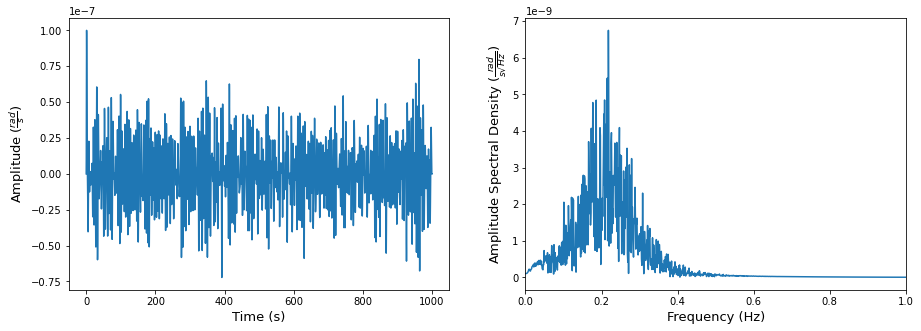

In [218]:
__makeplot_trace_and_spectrum(modeltrace, time_modeltrace, fmax=2*f_upper);

Possibility to write modeltrace and time axis to a stream as .mseed to load it in an other script. Load a trace enhances comparability since it is not randomly gereated each time.

In [219]:
# oname = f'data/syn_T{int(T)}_fs{int(sps)}_f{f_lower}-{f_upper}.mseed'

# __write_to_mseed(modeltrace, time_modeltrace, oname, sps)

In [220]:
# import pickle

# oname = f'data/testtrace_0.001-20Hz'

# __write_to_mseed(modeltrace, time_modeltrace, oname+".signal", sps)

# pickle.dump(time_modeltrace, open( oname+".time", "wb" ) )


#### Long real trace ... 

In [221]:

def __get_long_trace(f_lower, f_upper):

    from numpy import linspace
    
    rlas = read('/home/andbro/notebooks/Sagnac_processing/data/RLAS_HJZ_2021-02-10.mseed')

#     rlas_inv = read_inventory('/home/andbro/notebooks/Sagnac_processing/data/RLAS_HJZ.xml')

    # rlas.remove_response(inventory=rlas_inv, 
    #                      pre_filt=[0.001, 0.005, 45, 50], 
    #                      output="VEL",
    #                      water_level=60, 
    #                      plot=False,
    #                      ) 

    rlas.filter('bandpass', freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True)

    timeline = linspace(0, rlas[0].stats.delta*rlas[0].stats.npts, rlas[0].stats.npts)
    
    
    return rlas[0].data, timeline


In [222]:
# modeltrace, time_modeltrace = __get_long_trace(f_lower, f_upper)


In [223]:
# __makeplot_trace_and_spectrum(modeltrace, time_modeltrace, fmax=2*f_upper);

# Modulation

In [224]:

synthetic_signal, timeline = __modulation(modeltrace,
                                          time_modeltrace, 
                                          sgnc, 
                                          T, 
                                          sps, 
                                          modulation_index, 
                                          modulation_scheme,
                                         )



Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 2.54 sec


### Taper

In [225]:
# synthetic_signal = __tapering(synthetic_signal, taper_type='window', percent=0.2)

### Plots

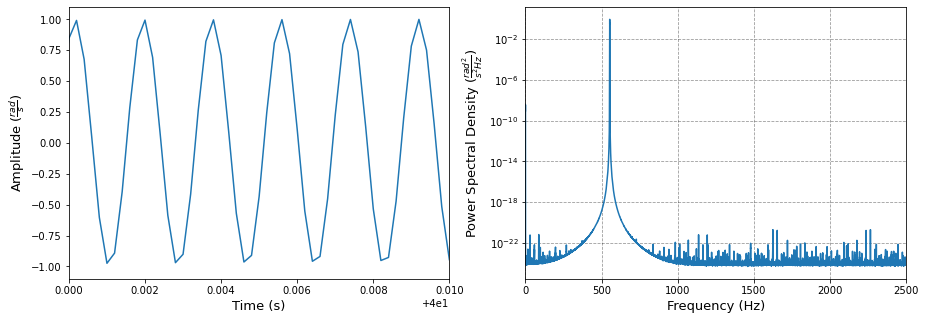

In [226]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=40, t2=40.01);

In [227]:
# __makeplot_modulated_signal(synthetic_signal,timeline);

### Downsample

The modulation has been performed with an oversampling factor to avoid erros. Now the result is resampled mimicing the real sampling of the analog signal.

In [228]:
# sps /= oversampling


# real_time = np.arange(0,T+1/sps,1/sps)

# tmp1 = np.interp(real_time, time_modeltrace, modeltrace)
# tmp2 = np.interp(real_time, modeltrace, time_modeltrace)
# tmp3 = np.interp(real_time, timeline, synthetic_signal)

# timeline = real_time

# modeltrace = tmp1
# time_modeltrace = tmp2
# synthetic_signal = tmp3

In [229]:
modeltrace = modeltrace[::oversampling]
time_modeltrace = time_modeltrace[::oversampling]

synthetic_signal = synthetic_signal[::oversampling]
timeline = timeline[::oversampling]

sps = 1/(timeline[1]-timeline[0])

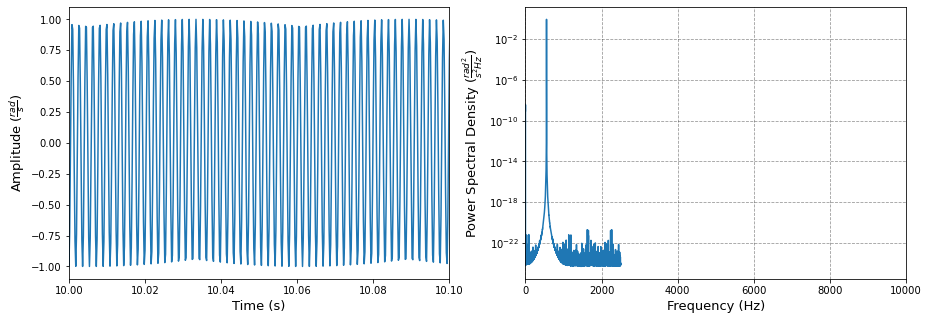

In [230]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=2*sps, t1=10, t2=10.1); 

In [231]:
# import pickle

# ofile = open("/home/andbro/notebooks/Sagnac_processing/data/model.syn","wb")

# pickle.dump(synthetic_signal, ofile)

# ofile.close()

## Read raw real

In [232]:
# st = read('/home/andbro/Documents/ROMY/data/BW.DROMY..FJZ.D.2021.049', 
#          starttime=UTCDateTime("2021-02-18 11:00"),
#          endtime=UTCDateTime("2021-02-18 11:00")+T,
#          )

# print(st[0].data.size)

# synthetic_signal = st[0].data

In [233]:
# trace = read('/home/andbro/Documents/ROMY/data/ROMY_BJZ_2021-02-18.mseed',
#             starttime= UTCDateTime("2021-02-18 11:00"), 
#             endtime=UTCDateTime("2021-02-18 11:00")+T
#             )

# modeltrace = trace[0].data

### Upsampling with Bandpass

In [234]:

def __resample_digital_signal(signal_in, fs, sampling_factor, taper=False):

    ''' 
    up-samping of the simulated digital signal 
    
    sig_in   = input signal
    fs       = sampling frequency of digital signal
    fac      = sampling factor (2 = double)
    taper    = True/False , to either taper or not taper output
    
    '''
    

    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a


    def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y


    def resampling(sig_in, factor, fs, case):

        if case == 1:
            sig_out = resample(sig_in,len(sig_in)*factor)

        elif case == 2:
            sig = list(sig_in); i=0

            while i < len(sig):
                sig.insert(i, 0.0)
                i += 2
            sig_out = np.array(sig)

        t_out = np.arange(0,len(sig_in)/fs,1/(fs*factor))

        return  (sig_out, t_out)



    #sig_dig_fil_res, tt_res = resampling(sig_dig_fil,2,fs,2)
    signal_out, time_out = resampling(signal_in, sampling_factor, fs, case=1)

    if taper:
        signal_out = np.hanning(signal_out.size) * sig_nal_out
        #signal_out = butter_bandpass_filter(sig_dig_res_tap,0.1,100,fs,4)
        

    ## _______________________________________________________________________________

#     fig, ax = plt.subplots(1,1,figsize=(15,5))

#     tt     = time_out
#     signal = signal_out
    
    
#     ax.plot(tt,signal,color='grey')

#     ax.scatter(tt,signal,s=15,color='black')

#     ax.scatter(tt[::2],signal[::2],s=15,color='red')
#     #ax.plot(tt[1::2],signal[1::2],color='darkred')


#     ax.set_xlim(0,5)
#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('Counts')

#     plt.show();
    
    ## _______________________________________________________________________________
   
    
    return signal_out, time_out
    

In [235]:

def __upsample_FIR(signal_in, sampling_factor, sps):
    
    from scipy.signal import upfirdn, resample_poly
    
    
    lower = 50
    upper = sampling_factor*lower
    
    signal_out = resample_poly(signal_in, upper, lower)
    
    time_out = np.arange(len(signal_out))/(sps*sampling_factor)
    
    return signal_out, time_out


In [236]:

def __interpolation(trace, time, T, sps):
    
    from scipy.signal import resample
    from numpy import arange
    
    ## interpolate modeltrace to sps 
    l1 = trace.size
    
    trace = resample(trace, int(T*sps+1))
#     time = resample(time, int(T*sps+1))    
    
    l2 = trace.size
    
    print(f"modeltrace is interpolated: {l1} samples --> {l2} samples")
#     print(f"time_modeltrace is interpolated: {l1} samples --> {l2} samples")

    time = arange(0, T+1/sps, 1/sps)

    return trace, time


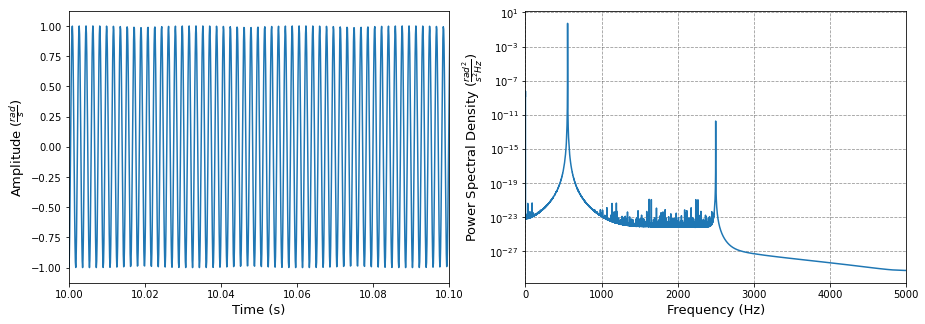

In [237]:
synthetic_signal2, timeline2 = __resample_digital_signal(synthetic_signal, sps, 2, taper=False)

__makeplot_trace_and_psd(synthetic_signal2, timeline2, fmax=sps, t1=10, t2=10.1); 

modeltrace is interpolated: 5000001 samples --> 5000001 samples


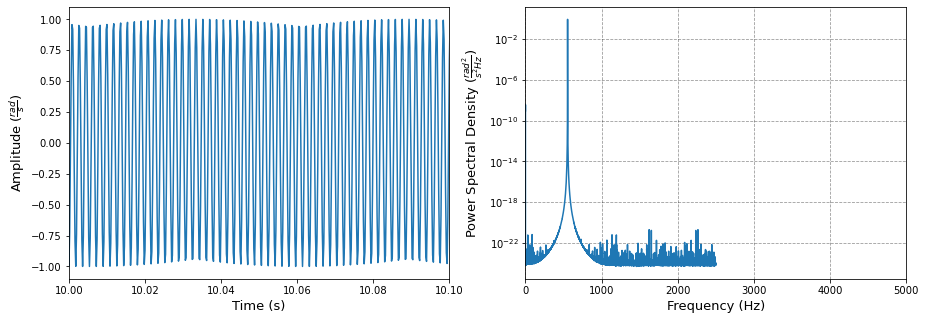

In [238]:
synthetic_signal3, timeline3 = __interpolation(synthetic_signal, timeline, T, sps)

__makeplot_trace_and_psd(synthetic_signal3, timeline3, fmax=sps, t1=10, t2=10.1); 

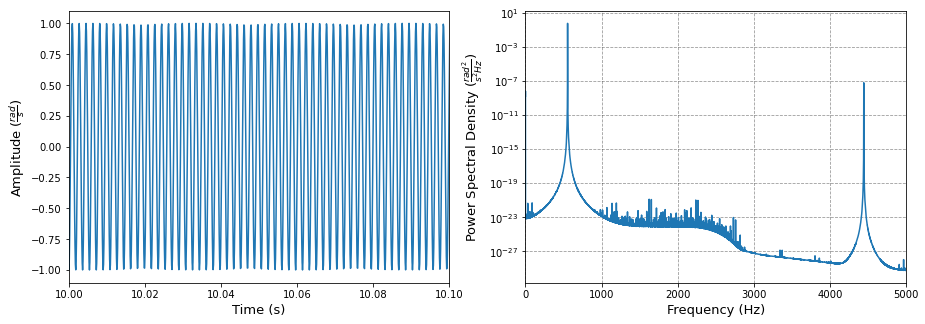

In [239]:
synthetic_signal4, timeline4 = __upsample_FIR(synthetic_signal, 2, sps)

__makeplot_trace_and_psd(synthetic_signal4, timeline4, fmax=sps, t1=10, t2=10.1); 

In [240]:

# def __resample_digital_signal(signal_in, fs, sampling_factor, taper=False):

#     ''' 
#     up-samping of the simulated digital signal 
    
#     sig_in   = input signal
#     fs       = sampling frequency of digital signal
#     fac      = sampling factor (2 = double)
#     taper    = True/False , to either taper or not taper output
    
#     '''
    

#     def butter_bandpass(lowcut, highcut, fs, order=5):
#         nyq = 0.5 * fs
#         low = lowcut / nyq
#         high = highcut / nyq
#         b, a = butter(order, [low, high], btype='band')
#         return b, a


#     def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#         b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#         y = lfilter(b, a, data)
#         return y


#     def resampling(sig_in, factor, fs, case):

#         if case == 1:
#             sig_out = resample(sig_in,len(sig_in)*factor)

#         elif case == 2:
#             sig = list(sig_in); i=0

#             while i < len(sig):
#                 sig.insert(i, 0.0)
#                 i += 2
#             sig_out = np.array(sig)

#         t_out = np.arange(0,len(sig_in)/fs,1/(fs*factor))

#         return  (sig_out, t_out)



#     #sig_dig_fil_res, tt_res = resampling(sig_dig_fil,2,fs,2)
#     signal_out, time_out = resampling(signal_in, sampling_factor, fs, case=1)

#     if taper:
#         signal_out = np.hanning(signal_out.size) * sig_nal_out
#         #signal_out = butter_bandpass_filter(sig_dig_res_tap,0.1,100,fs,4)
        

#     ## _______________________________________________________________________________

# #     fig, ax = plt.subplots(1,1,figsize=(15,5))

# #     tt     = time_out
# #     signal = signal_out
    
    
# #     ax.plot(tt,signal,color='grey')

# #     ax.scatter(tt,signal,s=15,color='black')

# #     ax.scatter(tt[::2],signal[::2],s=15,color='red')
# #     #ax.plot(tt[1::2],signal[1::2],color='darkred')


# #     ax.set_xlim(0,5)
# #     ax.set_xlabel('Time (s)')
# #     ax.set_ylabel('Counts')

# #     plt.show();
    
#     ## _______________________________________________________________________________
   
    
#     return signal_out, time_out
    

In [241]:

if bandpass:
    
#     synthetic_signal, timeline = __resample_digital_signal(synthetic_signal, sps, 2, taper=False)

    synthetic_signal, timeline = __upsample_FIR(synthetic_signal, 2, sps)
    
#     synthetic_signal, timeline = __interpolation(synthetic_signal, timeline, T, sps)
    sps = sps*2
    
    

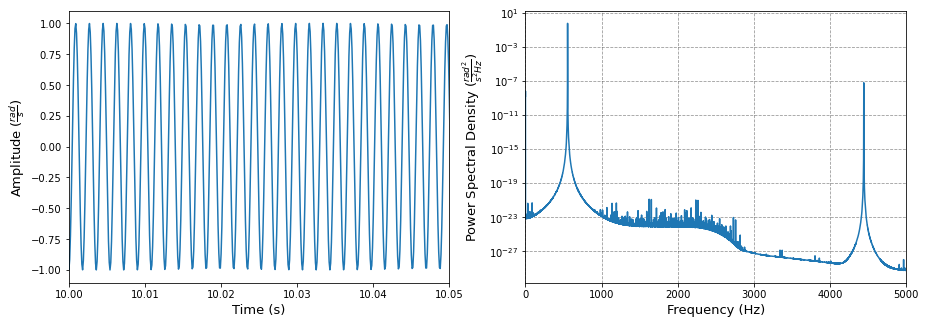

In [242]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=10, t2=10.05); 

# Demodulation

In order to evaluate the demodulated signal it is compared to the kown synthetic signalthe. For this, the median is substracted and 1% of the edges are cut off. Then both, the orignal and the retrieved signal are normalized and a cross-correlation calculated.

In [243]:

def __hibert_filter(sig_in, time_in, fs):
    
    '''
    estimating the instantaneous frequency by using the formula of Jo
    
    sig_in    = input signal
    time_in   = input timeline
    fs        = sampling frequency of digital signal
    '''
    
    ## calulcate hilbert transform
    hil0 = hilbert(sig_in)
    
    ## extract imaginary part of hilbert transform 
    hil = np.imag(hil0)
    
    
    ## calculate derivatives 
#     d_hil = np.gradient(hil, edge_order=1)*sps/(2*np.pi*sgnc)
#     d_sig = np.gradient(sig_in, edge_order=1)*sps/(2*np.pi*sgnc)
    d_hil = np.gradient(hil, edge_order=1)*sps
    d_sig = np.gradient(sig_in, edge_order=1)*sps
    
    delta_f_full = (sig_in * d_hil - d_sig * hil) / (2*np.pi*np.sqrt(sig_in**2 + hil**2))
# #     delta_f_full = (sig_in[1:]*np.diff(hil) - np.diff(sig_in) * hil[1:]) / (2*np.pi*np.sqrt(sig_in[1:]**2 + hil[1:]**2))

    ## extract real part
    delta_f = np.real(delta_f_full)
    
    
    ## instert nan value for time zero (exluded bevause of np.diff() ) 
    sum0, idx = 0, []
    for k, x in enumerate(delta_f):
        if np.isnan(x):
            sum0 += 1
            idx.append(k)
    
    if sum0 != 0:
        print(sum0, " nan found")
    
    for l in idx:
        delta_f[l] = 0

    
    ## _______________________________________________________________________________

#    return time_in[1:], delta_f
    return time_in, delta_f


In [244]:

def __demodulate(x, y, Twindow, sps):

    window_size = int(Twindow * sps)

    stepsize = int(window_size/2) 

    out1, out2 = np.array([]), np.array([])
    for i in tqdm(range(0,len(x), stepsize)):

        if int(i+window_size) > len(x):
            print(f"break for {i/sps}")
            break

        win1 = x[i:int(i+window_size)]
        win2 = y[i:int(i+window_size)]



        t, sig = __hibert_filter(win1, win2, sps)

    #     plt.plot(t[int(stepsize/2):window_size-int(stepsize/2)], sig[int(stepsize/2):window_size-int(stepsize/2)])
    #     plt.show();

        out1 = np.append(out1, sig[int(stepsize/2):window_size-int(stepsize/2)])
        out2 = np.append(out2, t[int(stepsize/2):window_size-int(stepsize/2)])
    #     plt.plot(out2,out1)

    return out1, out2


In [245]:

Twindow = 400 # seconds

demod_signal, time_demod_signal = __demodulate(synthetic_signal, timeline, Twindow, sps)



 67%|██████▋   | 4/6 [00:24<00:12,  6.06s/it]

break for 800.0



### Remove Offset

In [246]:
print(f"theo. Sagnac Frequencs: {sgnc} Hz")
print(f"Median Demodulated Signal: {np.median(demod_signal)}")

# demod_signal = demod_signal - sgnc
demod_signal = demod_signal - np.median(demod_signal)

theo. Sagnac Frequencs: 553.6690497710365 Hz
Median Demodulated Signal: 542.6731049374761


### Padding Edges

In [247]:
## samples from left and right to be ignored due to dynamic demodulation
index1 = int(time_demod_signal[0]*sps)

if bandpass:
    index2 = int(int(T-time_demod_signal[-1])*sps)+2
else:
    index2 = int(int(T-time_demod_signal[-1])*sps)+1

## padding demodulated signal at the edges
demod_signal = np.pad(demod_signal, (index1, index2), constant_values=(0, 0))

## adjust time axis
time_demod_signal = np.arange(len(demod_signal))/sps



time_demod_signal.size, demod_signal.size

(10000002, 10000002)

## Downsampling 

In [248]:

def __downsample(signal_in, sps, ds_factor=2):


    tmp = Trace(signal_in)
    tmp.stats.delta = 1/sps
    tmp.filter('lowpass', freq=5000-1, corners=8, zerophase=True)
    tmp.resample(int(sps/2))
    signal_out = tmp.data

    sps = int(sps/ds_factor)

#     signal_out = signal_out[::ds_factor]
    time_out = np.arange(signal_out.size)/sps

    return signal_out, time_out, sps


In [249]:

if bandpass:

    downsampling_factor = 2

    sps0 = sps ## prevent overwriting
    demod_signal, time_demod_signal, sps = __downsample(demod_signal, sps0, ds_factor=downsampling_factor)
#     modeltrace, time_modeltrace, sps = __downsample(modeltrace, sps0, ds_factor=downsampling_factor)
    

    ## adjust index after resampling
    index1=int(index1/downsampling_factor)
    index2=int(index2/downsampling_factor)
    
    
    
demod_signal.size, time_demod_signal.size, modeltrace.size, time_modeltrace.size

(5000001, 5000001, 5000001, 5000001)

### Normalize

In [250]:
## apply conversion counts -> volt of obsidian digitizer
demod_signal *= 0.59604645e-6

In [251]:
max(demod_signal), max(modeltrace)

(3.6536174878551805e-07, 9.9999999999999995e-08)

In [252]:

if normalize:
    demod_signal = __normalize(demod_signal)
    modeltrace   = __normalize(modeltrace)

#     demod_signal_norm = __tapering(demod_signal_norm, 'flanks', percent=0.1)

### Cross-Correlation

In [253]:
cross_corr = correlate(demod_signal, modeltrace, mode='same')

cross_corr_lags = np.arange(-cross_corr.size//2+1,cross_corr.size//2+1,1)

### Final Plotting

In [254]:
if bandpass:
    cut1 = int(index1)
    cut2 = int(len(demod_signal)-index2)
else:
    cut1 = int(index1)
    cut2 = int(len(demod_signal)-index2)   
    

cut1,cut2

(500000, 4500000)


optimized: original -  0.177 * model + 0.0



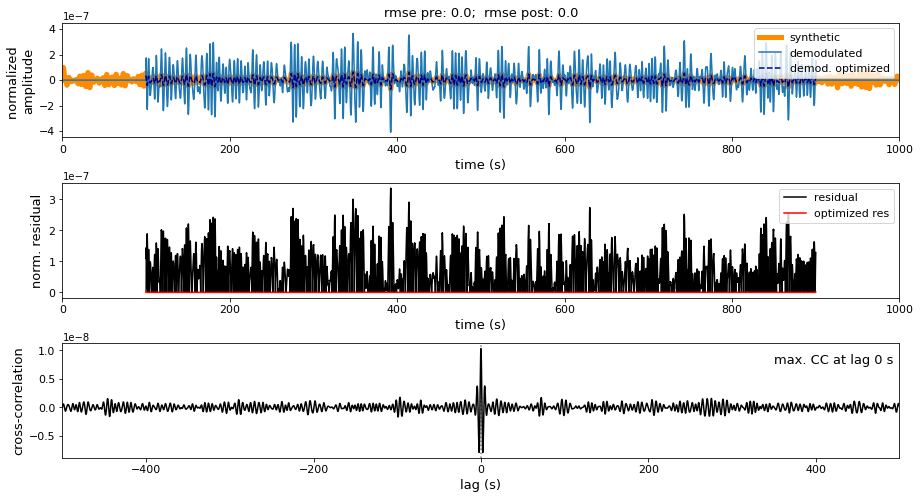

In [257]:
fig = __makeplot_demodulation_quality(time_modeltrace, 
                                      modeltrace, 
                                      time_demod_signal,
                                      demod_signal,
                                      cross_corr,
                                      cross_corr_lags,
                                      cut1,
                                      cut2,
                                     );

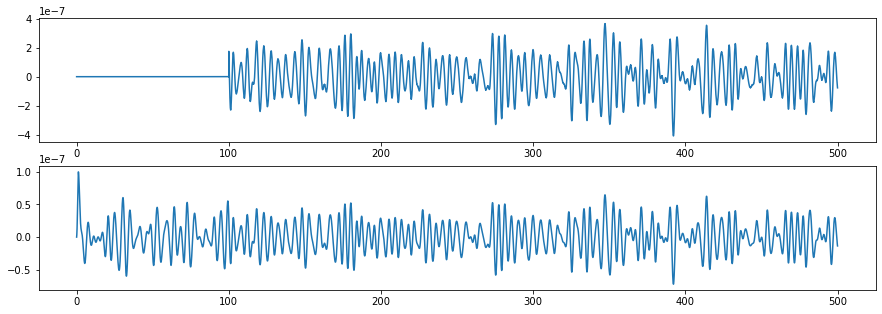

In [259]:
time_modeltrace = np.linspace(0, T, len(modeltrace))

fig, ax = plt.subplots(2,1, figsize=(15,5))

z1 = int(len(demod_signal)/2)
z2 = int(len(modeltrace)/2)
         
ax[0].plot(time_demod_signal[0:z1],demod_signal[0:z1])
ax[1].plot(time_modeltrace[0:z2], modeltrace[0:z2])


### Save Plot

In [ ]:
# pname = f"{syn_signal}_{f_lower}-{f_upper}_T{int(T)}_fs{int(sps)}_mi{modulation_index}_S{int(sgnc)}_case{modulation_scheme}.pdf"

# fig.savefig(f"plots/{pname}", dpi=300, format='pdf')

In [ ]:

# import matplotlib.pyplot as plt
# from numpy import sqrt, mean


# def __makeplot_demodulation_quality(time_modeltrace, modeltrace, time_demod_signal, demod_signal, cross_corr, cross_corr_lags, c1, c2):
    
#     def __minimize_residual(model, original):

#         from scipy.optimize import leastsq

#         ## define cost function
#         def __cost_function(params, x, y):
#             a, b = params[0], params[1]
#             residual = y-(a*x+b)
#             return residual

#         ## initials 
#         params = [1,0]

#         result = leastsq(__cost_function, params, (model, original))

#         model_new = model * result[0][0] + result[0][1]

#         print(f'\noptimized: original -  {round(result[0][0],3)} * model + {round(result[0][1],3)}\n')

#         residual = (model_new - original)
#         return residual, model_new

    
#     ## ______________________________________

#     residual_pre_opt  = modeltrace[c1:c2]-demod_signal[c1:c2]
    
#     residual_post_opt, demod_signal_opt  = __minimize_residual(demod_signal[c1:c2], modeltrace[c1:c2])

#     print(type(residual_pre_opt), type(residual_post_opt))
#     print(len(residual_pre_opt), len(residual_post_opt))
       
    
#     max_amp = max(abs(demod_signal))
    
#     rmse_pre_opt  = abs(sqrt(mean(residual_pre_opt**2)))
#     rmse_post_opt = abs(sqrt(mean(residual_post_opt**2)))
    
    
#     ## ________________________________________________
#     ## plotting
    
#     fig, ax = plt.subplots(3, 1, figsize=(15,8))

#     font = 13
    
#     plt.subplots_adjust(hspace = 0.4)
    
#     # ---------------
#     ax[0].plot(time_modeltrace, modeltrace, color='darkorange', linewidth=5)
#     ax[0].plot(time_demod_signal, demod_signal)
# #     ax[0].plot(time_demod_signal[c1:c2], demod_signal_opt, color='darkblue', linestyle='--')

#     ax[0].set_xlabel("time (s)", fontsize=font)
#     ax[0].tick_params(axis='both', labelsize=font-2)
    
        
#     ax[0].set_ylim(-max_amp-0.1*max_amp, max_amp+0.1*max_amp)
#     ax[0].set_ylabel('normalized \namplitude', fontsize=font)
    
#     # ---------------
#     ax[1].plot(time_demod_signal[c1:c2], abs(residual_pre_opt), color='k')
#     ax[1].plot(time_demod_signal[c1:c2], abs(residual_post_opt), color='r')


    
#     ax[1].set_xlabel("time (s)", fontsize=font)
#     ax[1].tick_params(axis='both', labelsize=font-2)
#     ax[1].set_ylabel('norm. residual', fontsize=font)
    
#     ax[1].set_xlim(time_demod_signal[0], time_demod_signal[-1])
    
# #     x1 = 0.1*time_demod_signal.size*(time_demod_signal[1]-time_demod_signal[0])
# #     y1 = 0.75*max(residual_pre_opt)    
# #     print(max(residual_post_opt))
# #     ax[1].text(x1, y1, f'rmse pre: {round(rmse_pre_opt,5)} \nrmse post: {round(rmse_post_opt,5)}', fontsize=font)    
    
#     ax[0].set_title(f'rmse pre: {round(rmse_pre_opt,5)};  rmse post: {round(rmse_post_opt,5)}', fontsize=font)
    
#     # ---------------
#     ax[2].axvline(0.0, color="grey", ls=":")
#     ax[2].plot(cross_corr_lags*(time_demod_signal[1]), cross_corr,'k')
    
#     ax[2].set_xlabel('lag (s)', fontsize=font)
#     ax[2].tick_params(axis='both', labelsize=font-2)
#     ax[2].set_ylabel('cross-correlation', fontsize=font)
    
#     x0 = 0.70*max(cross_corr_lags)*(time_demod_signal[1]-time_demod_signal[0])
#     y0 = 0.75*max(cross_corr)
    
#     ax[2].text(x0, y0, f'max. CC at lag {cross_corr_lags[abs(cross_corr).argmax()]} s', fontsize=font)



#     ax[0].legend(['synthetic', 'demodulated', 'demod. optimized'], loc="upper right", fontsize=font-2)
#     ax[1].legend(['residual', 'optimized res'], loc="upper right", fontsize=font-2)

#     ax[0].set_xlim(time_demod_signal[0], time_demod_signal[-1])
#     ax[1].set_xlim(time_demod_signal[0], time_demod_signal[-1])
#     ax[2].set_xlim(-time_demod_signal[-1]/2, time_demod_signal[-1]/2)

#     plt.show();
    
#     return fig

In [ ]:
# fig = __makeplot_demodulation_quality(time_modeltrace, 
#                                       modeltrace, 
#                                       time_demod_signal,
#                                       demod_signal,
#                                       cross_corr,
#                                       cross_corr_lags,
#                                       c1,
#                                       c2,
#                                      );